#One element solution with and without nonlinear geometrics.

Author: Jukka Aho

Email: <jukka.aho@kapsi.fi>

In [1]:
tic()

0x00023c5cd89a9c57

We consider here linear quadrangle element and evaluate solution for it. It has been verified using Elmer that the correct solution for minimum displacement in tip is $u_\mathrm{min,nonlinear}$ = -2.22224475 for geometrically nonlinear case and  $u_\mathrm{min,linear} = -2.18056991$ for linear case.

Solution domain is $\Omega = [0, 10] \times [0, 1] \in \mathbb{R}^2$ and we are having $F=-2 \mathrm{N}$ nodal force in $(10, 1)$. $E=90$, $\nu=0.25$. Left side is fixed, $u|_{x=0}=0$.

Geometry, material definitions and shape functions:

In [2]:
X = [[0.0 10.0 10.0 0.0],
     [0.0  0.0  1.0 1.0]]

# Partial derivatives of bilinear Lagrange polynomials
dNdξ(ξ) = [[-(1-ξ[2])/4.0    -(1-ξ[1])/4.0],
           [ (1-ξ[2])/4.0    -(1+ξ[1])/4.0],
           [ (1+ξ[2])/4.0     (1+ξ[1])/4.0],
           [-(1+ξ[2])/4.0     (1-ξ[1])/4.0]]    

E = 90
ν = 0.25
μ = E/(2*(1+ν))
λ = E*ν/((1+ν)*(1-2*ν))
λ = 2*λ*μ/(λ + 2*μ)
μ, λ

(36.0,24.0)

## Internal force vector:

In [3]:
function f_int(X, u, dNdξ, λ, μ, dim=2)
    T = zeros(size(X))
    I = eye(dim)
    
    function J(ξ)
        Jᵀ = X*dNdξ(ξ)
        ∇N = inv(Jᵀ)*dNdξ(ξ)'
        ∇u = u*∇N'
        F = I + ∇u  # Deformation gradient
        E = 1/2*(∇u' + ∇u + ∇u'*∇u)  # Green-Lagrange strain tensor
        P = λ*trace(E)*I + 2*μ*E  # PK1 stress tensor
        S = F*P  # PK2 stress tensor
        return S*∇N*det(Jᵀ)
    end

    a = 1/sqrt(3)
    ipoints = [[-a -a], [a -a], [a a], [-a a]]
    iweights = [1 1 1 1]

    for m = 1:length(iweights)
        w = iweights[m]
        ξ = ipoints[m, :]
        T += w*J(ξ)
    end

    return T

end

f_int (generic function with 2 methods)

## Solution

In [4]:
using NLsolve

function solve()

    free_dofs = [3, 4, 5, 6]
    u = zeros(2, 4)
    F = zeros(2, 4)
    F[2, 3] = -2.0

    function f(u_)
        u[free_dofs] = u_
        T = f_int(X, u, dNdξ, λ, μ)
        R = T-F
        return R[free_dofs]
    end

    # Go!
    sol = nlsolve(not_in_place(f), zeros(4), store_trace=true, show_trace=true)
    println(sol)
    u[free_dofs] = sol.zero
    return u
end

u = solve()

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.000000e+00              NaN
     1     1.000142e+00     2.257867e-03
     2     9.933192e-01     4.422932e-03
     3     9.961075e-01     8.847632e-03
     4     9.855335e-01     1.769324e-02
     5     9.738205e-01     3.538698e-02
     6     9.612786e-01     7.077382e-02
     7     9.404424e-01     1.415511e-01
     8     9.493268e-01     2.831322e-01
     9     1.157757e+00     5.665408e-01
    10     6.914588e-01     2.840319e-01
    11     6.914588e-01     0.000000e+00
    12     5.805109e-01     2.845511e-01
    13     5.805109e-01     0.000000e+00
    14     4.993552e-01     2.851202e-01
    15     4.993552e-01     0.000000e+00
    16     4.100475e-01     2.858343e-01
    17     4.100475e-01     0.000000e+00
    18     3.195632e-01     2.866934e-01
    19     3.195632e-01     0.000000e+00
    20     2.284246e-01     2.877431e-01
    21     1.444984e-01     3.012556e-01
    22     8.01566

2x4 Array{Float64,2}:
 0.0  -0.399145  -0.0722858  0.0
 0.0  -2.17799   -2.22224    0.0

Difference to Elmer solution is

In [5]:
abs(u[2, 3] - -2.22224475)

4.3690935314089074e-9

Linear solution is achieved by assuming small deformation, i.e. :
    
    F = I + ∇u ≈ I
    E = 1/2*(∇u' + ∇u + ∇u'*∇u) ≈ 1/2*(∇u' + ∇u)


**OFFTOPIC:** Here we should put something like

    using JuliaFEM
    test_allclose(u[2, 3], -2.22224457, tol = ...)

and get a nice green "**PASSED**" if everything is ok at this point, otherwise assertionerror

## Notes about linearization

For more robust solution, we shoud get analytical Jacobian for nonlinear system of equations. If not given it's probably some sort of finite difference approximation, i.e.

In [6]:
function Lin(f, h=1.0e-6)

    function D(x)
        J_approx = zeros((8, 8))
        for i=1:8
            Δx = zeros(2, 4)
            Δx[i] += h
            Δf = f(x+Δx) - f(x)
            J_approx[i, :] = Δf[:]/h
        end
        return J_approx
    end

    return D

end

J_approx = Lin(u -> f_int(X, u, dNdξ, λ, μ))
J_approx(u)

8x8 Array{Float64,2}:
  119.461      13.4859     61.8587   …   -26.0246  -113.693       2.80636
   13.486     309.575      15.6443      -148.518     -3.10971  -316.139  
   61.8587     15.6443    130.663        -53.2775   -60.0524      1.5741 
    9.73232   155.082      36.0592      -303.876      1.51268  -163.427  
  -67.6267    -26.0207   -132.47          63.0313    56.5391     10.2937 
  -26.0246   -148.518     -53.2777   …   299.44      16.2711    152.956  
 -113.693      -3.10985   -60.0524        16.2711   117.207     -14.6739 
    2.80624  -316.14        1.57406      152.956    -14.674     326.611  

A more elegant solution is to use automatic differentiation to get analytical tangent stiffness matrix

In [7]:
using ForwardDiff

function T!(u, T)
    T[:] = f_int(X, reshape(u, 2, 4), dNdξ, λ, μ)
end

J_analytical = forwarddiff_jacobian(T!, Float64, fadtype=:dual, n=8, m=8)
J_analytical(reshape(u, 8))

8x8 Array{Float64,2}:
  119.461      13.486      61.8587   …   -26.0246  -113.693       2.80625
   13.486     309.576      15.6443      -148.518     -3.10973  -316.14   
   61.8587     15.6443    130.663        -53.2776   -60.0524      1.57406
    9.73233   155.082      36.0593      -303.877      1.51267  -163.427  
  -67.6267    -26.0206   -132.47          63.0312    56.539      10.2937 
  -26.0246   -148.518     -53.2776   …   299.439     16.271     152.956  
 -113.693      -3.10973   -60.0524        16.271    117.207     -14.674  
    2.80625  -316.14        1.57406      152.956    -14.674     326.611  

Difference is in smooth situations quite small, but analytical is of course faster.

In [8]:
norm(J_approx(u) - J_analytical(reshape(u, 8)))

0.000998738079715485

If we use this analytical Jacobian we should get quadratic convergence when using Newton-Rhapson method:

In [9]:
function solve2()

    free_dofs = [3, 4, 5, 6]
    u = zeros(2, 4)
    F = zeros(2, 4)
    F[2, 3] = -2.0

    function f(u_)
        u[free_dofs] = u_
        T = f_int(X, u, dNdξ, λ, μ)
        R = T-F
        return R[free_dofs]
    end

    function g(u_)
        u[free_dofs] = u_
        J = J_analytical(reshape(u, 8))
        return J[free_dofs, free_dofs]
    end

    # Go!
    sol = nlsolve(not_in_place(f, g), zeros(4), method = :newton, store_trace=true, show_trace=true)
    println(sol)
    u[free_dofs] = sol.zero
    return u
end

u = solve2()

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     2.000000e+00              NaN
     1     1.985767e+00     3.756746e-01
     2     1.933311e+00     3.652956e-01
     3     1.855451e+00     3.896874e-01
     4     1.749547e+00     4.460338e-01
     5     1.581001e+00     5.270850e-01
     6     1.331440e+00     8.104083e-01
     7     8.751161e-02     2.235404e-01
     8     2.570554e-04     1.112294e-02
     9     3.202487e-09     3.961907e-05
Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [0.0,0.0,0.0,0.0]
 * Zero: [-0.3991450608223195,-2.1779892314495743,-0.072285826868806,-2.22224475412425]
 * Inf-norm of residuals: 0.000000
 * Iterations: 9
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 110
 * Jacobian Calls (df/dx): 18


2x4 Array{Float64,2}:
 0.0  -0.399145  -0.0722858  0.0
 0.0  -2.17799   -2.22224    0.0

Clearly the last iterations are converging quadratic speeds. Own naive implementation of solver would be:

In [10]:
function solve3()

    free_dofs = [3, 4, 5, 6]
    u = zeros(2, 4)
    F = zeros(2, 4)
    F[2, 3] = -2.0

    function f(u_)
        u[free_dofs] = u_
        T = f_int(X, u, dNdξ, λ, μ)
        R = T-F
        return R[free_dofs]
    end

    function g(u_)
        u[free_dofs] = u_
        J = J_analytical(reshape(u, 8))
        return J[free_dofs, free_dofs]
    end

    u2 = zeros(4)
    for i=1:7
        du = g(u2) \ -f(u2)
        u2 += du
        println("norm = ",norm(du))
    end
    u[free_dofs] = u2
    return u
end

u = solve3()

norm = 3.0900221367289094
norm = 0.3212131602153428
norm = 0.04043178194002758
norm = 0.0009291101052123099
norm = 1.5638899074064188e-7
norm = 1.036219989655546e-14
norm = 3.130358566071589e-16


2x4 Array{Float64,2}:
 0.0  -0.399145  -0.0722858  0.0
 0.0  -2.17799   -2.22224    0.0

I don't know what NLsolve does because it takes a bit longer to converge?

## Comparison of results

At end we do compare results between linear and nonlinear systems and put all together.

In [11]:
function f_int(X, u, dNdξ, λ, μ, dim=2; nlgeom=true)
    T = zeros(size(X))
    I = eye(dim)

    function J(ξ)
        Jᵀ = X*dNdξ(ξ)
        ∇N = inv(Jᵀ)*dNdξ(ξ)'
        ∇u = u*∇N'
        F = I  # Deformation gradient for small deformations
        E = 1/2*(∇u' + ∇u)  # Small strain tensor
        if nlgeom  # .. if nonlinear geometry
            F += ∇u  # .. add nonlinear part to deformation gradient, and
            E += 1/2*(∇u'*∇u)  # add nonlinear part to strain tensor => Green-Lagrange strain tensor
        end
        P = λ*trace(E)*I + 2*μ*E  # PK1 stress tensor
        S = F*P  # PK2 stress tensor
        return S*∇N*det(Jᵀ)
    end

    a = 1/sqrt(3)
    ipoints = [[-a -a], [a -a], [a a], [-a a]]
    iweights = [1 1 1 1]

    for m = 1:length(iweights)
        w = iweights[m]
        ξ = ipoints[m, :]
        T += w*J(ξ)
    end

    return T

end

function Lin(f, h=1.0e-6)

    function D(x)
        J_approx = zeros((8, 8))
        for i=1:8
            Δx = zeros(2, 4)
            Δx[i] += h
            Δf = f(x+Δx) - f(x)
            J_approx[i, :] = Δf[:]/h
        end
        return J_approx
    end

    return D

end

function solve4!(F, u; nlgeom=true, analytical_jacobian=false)

    free_dofs = [3, 4, 5, 6]

    # Tangent stiffness matrix
    function T!(u, T)
        T[:] = f_int(X, reshape(u, 2, 4), dNdξ, λ, μ, nlgeom=nlgeom)
    end
    if analytical_jacobian
        Jacobian = ForwardDiff.forwarddiff_jacobian(T!, Float64, fadtype=:dual, n=8, m=8)
    else
        Jacobian = Lin(u -> f_int(X, u, dNdξ, λ, μ))
    end

    # Assembly of residual vector R(u) = T(u) - F(u)
    function f(u_)
        u[free_dofs] = u_
        T = f_int(X, u, dNdξ, λ, μ, nlgeom=nlgeom)
        return (T-F)[free_dofs]
    end

    # Derivative of residual vector w.r.t displacement field u, "tangent stiffness"
    function g(u_)
        u[free_dofs] = u_
        if analytical_jacobian
            J = Jacobian(reshape(u, 8))
        else
            J = Jacobian(u)
        end
        return J[free_dofs, free_dofs]
    end

    # Go!
    #sol = nlsolve(not_in_place(f, g), zeros(4), method=:newton)  # not working as expected
    #sol = nlsolve(not_in_place(f), zeros(4))  # working, but not quadratic convergence

    # working, very well :)
    u2 = zeros(4)
    for i=1:100
        du = g(u2) \ -f(u2)
        u2 += du
        if norm(du) < 1.0e-6
            #println("norm = ",norm(du), " converged in ", i, " iterations")
            break
        end
    end

    #u0[free_dofs] = sol.zero
    u0[free_dofs] = u2
    return u0
end

u0 = zeros(2, 4)
F = zeros(2, 4)
F[2, 3] = -20.0
solve4!(F, u0; nlgeom=true, analytical_jacobian=true)

2x4 Array{Float64,2}:
 0.0  -10.0735   -8.83486  0.0
 0.0  -10.4167  -11.8171   0.0

In [12]:
F = zeros(2, 4)
N = 41
F[2, 3] = -20.0
uall = zeros(2, 4, 2, N)
u0 = zeros(2, 4)
t = linspace(0, 1, N)
for i = 1:N
    @printf "Solving %2i F = %8.3f  " i t[i]*F[2, 3]
    u0 = solve4!(t[i]*F, u0; nlgeom=false, analytical_jacobian=false)
    uall[:, :, 1, i] = u0
    @printf "%8.3f" u0[2, 3]
    u0 = solve4!(t[i]*F, u0; nlgeom=true, analytical_jacobian=true)
    uall[:, :, 2, i] = u0
    @printf "%8.3f" u0[2, 3]
    println()
end

Solving  1 F =   -0.000     0.000   0.000
Solving  2 F =   -0.500    -0.545  -0.549
Solving  3 F =   -1.000    -1.090  -1.103
Solving  4 F =   -1.500    -1.635  -1.662
Solving  5 F =   -2.000    -2.181  -2.222
Solving  6 F =   -2.500    -2.727  -2.783
Solving  7 F =   -3.000    -3.291  -3.343
Solving  8 F =   -3.500    -3.822  -3.899
Solving  9 F =   -4.000    -4.361  -4.449
Solving 10 F =   -4.500    -4.906  -4.992
Solving 11 F =   -5.000    -5.451  -5.526
Solving 12 F =   -5.500    -5.997  -6.047
Solving 13 F =   -6.000    -6.542  -6.554
Solving 14 F =   -6.500    -7.087  -7.045
Solving 15 F =   -7.000    -7.632  -7.516
Solving 16 F =   -7.500    -8.177  -7.965
Solving 17 F =   -8.000    -8.722  -8.388
Solving 18 F =   -8.500    -9.267  -8.783
Solving 19 F =   -9.000    -9.813  -9.145
Solving 20 F =   -9.500   -10.358  -9.474
Solving 21 F =  -10.000   -10.903  -9.767
Solving 22 F =  -10.500   -11.448 -10.025
Solving 23 F =  -11.000   -11.993 -10.250
Solving 24 F =  -11.500   -12.538 

In [13]:
import PyPlot

INFO: Loading help data...


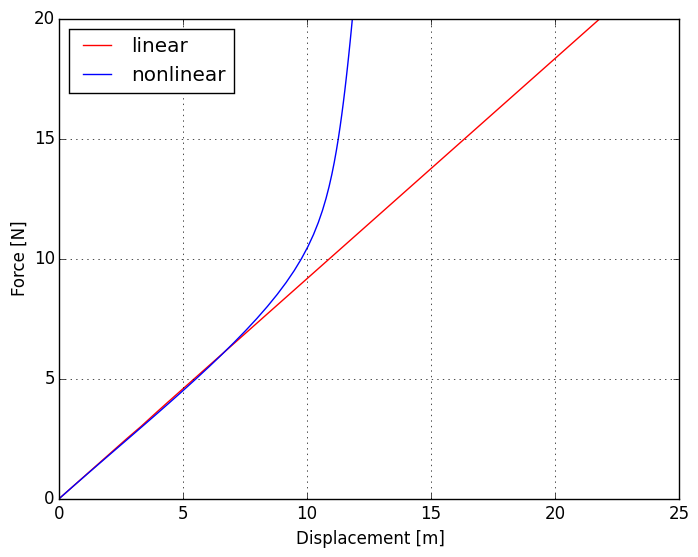

PyObject <matplotlib.text.Text object at 0x1158e5c90>

In [14]:
PyPlot.plot(-reshape(uall[2, 3, 1, :], N), -t*F[2, 3], color="red", linewidth=1.0, label="linear")
PyPlot.plot(-reshape(uall[2, 3, 2, :], N), -t*F[2, 3], color="blue", linewidth=1.0, label="nonlinear")
PyPlot.legend(loc="best")
PyPlot.grid()
PyPlot.xlabel("Displacement [m]")
PyPlot.ylabel("Force [N]")

Last remarks. For some unknown reason this notebooks takes occasionally a very long time to complete for 40 different solutions. Sometimes NLsolve takes a very long time when using Newton algorithm. Without Newton all passes well. Actually my implementation of Newton method does not have any problems with speed.

In [15]:
toc()

elapsed time: 57.255576466 seconds


57.255576466